# Tarea Semana 5 ‚Äî CNN + Transfer Learning
**Equipo:** Alan De Loa, Leonardo Lopez, Isaac Zaragoza, Luis Diaz, Luis Guzman  
**Fecha:**  28-10-2025

**Objetivo:** En esta tarea se busca construir y evaluar un modelo de Deep Learning implementando una red neuronal Convolucional (CNN) con Transfer Learning, t√©cnica que permite aprovechar el conocimiento adquirido por una red previamente entrenada con un conjunto de datos para aplicarlo a un problema mas espec√≠fico.

## 1) Introducci√≥n

El objetivo de este notebook es construir y evaluar un modelo de *Deep Learning* capaz de **clasificar im√°genes de frutas** utilizando el conjunto de datos **Fruits360**, disponible p√∫blicamente en plataformas como Kaggle y TensorFlow datasets.

El conjunto de datos **Fruits360** contiene miles de im√°genes de frutas y verduras tomadas en diferentes condiciones de iluminaci√≥n, posiciones y √°ngulos. Cada imagen est√° asociada a una etiqueta que indica el tipo de fruta (manzana, banana, uva, cereza, etc).

Para abordar esta tarea, se implementar√° una **Red Neuronal Convolucional (CNN)** basada en el modelo preentrenado **NASNetMobile**, utilizando la t√©cnica de Transfer Learning. Esto nos permitir√° aprovechar las caracter√≠sticas previamente aprendidas por la red en el conjunto de datos **ImageNet**, ajustando solamente las capas finales para adaptarse a la clasificaci√≥n de frutas.

Posteriormente, se aplica una segunda etapa de entrenamiento conocida como **Fine-Tuning**, en la que se liberan las √∫ltimas capas convolucionales del modelo base para mejorar la adaptaci√≥n a los patrones espec√≠ficos del conjunto Fruits360.

Con este enfoque se busca **mejorar la precisi√≥n del modelo** y **reducir el tiempo de entrenamiento**, para as√≠ demostrar que Transfer Learning es una herramienta poderosa para resolver problemas de visi√≥n por computadora en contextos donde los datos o los recursos son limitados.

## 2) Exploraci√≥n, explicaci√≥n y limpieza de datos

### 2.1 Fuente y contexto del dataset
El conjunto de datos **Fruits360** fue desarrollado por Horea Muresan y Mihai Oltean en la Universidad T√©cnica de Cluj-Napoca (Rumania) y esta disponible en Kaggle y TensorFlow Datasets.

El dataset contiene im√°genes de **frutas y verduras** tomadas en un fondo blanco, giradas 360 grados para captar m√∫ltiples vistas de cada objeto. El conjunto incluye aproximadamente:
- **90 483 muestras** im√°genes en total.  
- **131 clases** de frutas y verduras.
- Cada imagen tiene una resoluci√≥n de **100 x 100 p√≠xeles** y esta en **color RGB**.  

Las im√°genes se encuentran divididas en dos carpetas:   
- **67 692 im√°genes** para entrenamiento. (~75%)
- **22 688 im√°genes** para prueba. (~25%)

Para este proyecto, todas las im√°genes fueron redimensionadas a 128 x 128 p√≠xeles para ser compatibles con el modelo **NASNetMobile**.

El objetivo de este trabajo es que el modelo sea capaz de **clasificar correctamente el tipo de fruta presente en una imagen**, aprovechando las capacidades de extracci√≥n de caracter√≠sticas de una red preentrenada.

In [5]:
import os
import zipfile
import urllib.request

# URL del dataset Fruits360 en GitHub
url = "https://github.com/Horea94/Fruit-Images-Dataset/archive/refs/heads/master.zip"
zip_path = "fruits.zip"

# Descargar si no existe ya
if not os.path.exists(zip_path):
    print("Descargando Fruits360...")
    urllib.request.urlretrieve(url, zip_path)
    print("Descarga completada")

# Descomprimir si no existe la carpeta
if not os.path.exists("Fruit-Images-Dataset-master"):
    print("Descomprimiendo dataset...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(".")
    print("Descompresi√≥n lista")
else:
    print("Dataset ya descomprimido")


Descargando Fruits360 (‚âà300 MB)...
Descarga completada ‚úÖ
Descomprimiendo dataset...
Descompresi√≥n lista ‚úÖ


En esta secci√≥n se cargan las im√°genes del conjunto de datos Fruits360, dividi√©ndolas en dos subconjuntos principales:
- **Entrenamiento**: utilizado para que el modelo aprenda de patrones visuales de las frutas.  
- **Prueba**: empleado para evaluar el rendimiento final del modelo despu√©s del entrenamiento.

Utilizamos un batch de 32 lo que significa que el modelo procesar√° 32 im√°genes por paso durante el entrenamiento, lo cual mejora la eficiencia y estabilidad.

Para verificar que las im√°genes se hayan cargado correctamente, se muestra una cuadr√≠cula con 9 imagenes de diferentes frutas.

Found 67692 files belonging to 131 classes.
Found 22688 files belonging to 131 classes.

 Resumen del conjunto de datos Fruits360:
- Im√°genes de entrenamiento: 67692
- Im√°genes de prueba: 22688
- Total de clases: 131
- Ejemplo de clases: Apple Braeburn, Apple Crimson Snow, Apple Golden 1, Apple Golden 2, Apple Golden 3, Apple Granny Smith, Apple Pink Lady, Apple Red 1, Apple Red 2, Apple Red 3 ...


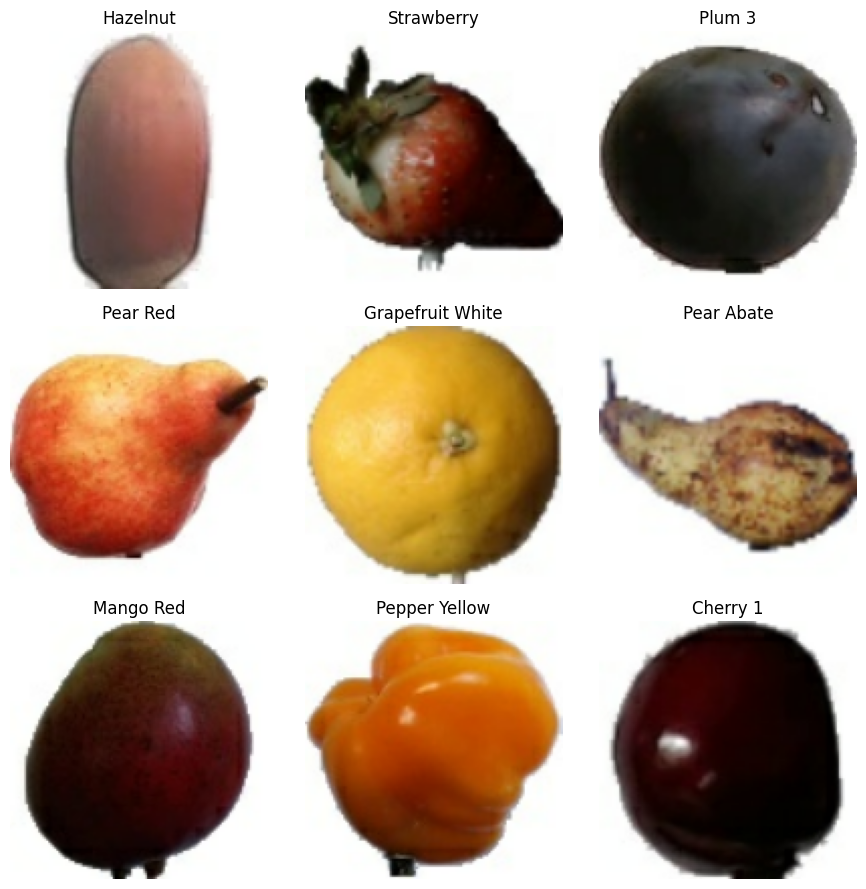

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt

train_dir = "Fruit-Images-Dataset-master/Training"
test_dir = "Fruit-Images-Dataset-master/Test"

# Reducimos tama√±o de imagen y batch para hacerlo m√°s eficiente
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Cargar conjunto de entrenamiento
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=123
)

# Cargar conjunto de prueba
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_train = len(train_ds.file_paths)
num_test = len(test_ds.file_paths)
num_classes = len(class_names)

print("\n Resumen del conjunto de datos Fruits360:")
print(f"- Im√°genes de entrenamiento: {num_train}")
print(f"- Im√°genes de prueba: {num_test}")
print(f"- Total de clases: {num_classes}")
print(f"- Ejemplo de clases: {', '.join(class_names[:10])} ...")

# Visualizaci√≥n de algunas im√°genes
plt.figure(figsize=(9, 9))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

### 2.2 Limpieza y transformaci√≥n de los datos
El conjunto de datos **Fruits360** no requiere un proceso de limpieza, ya que todas las im√°genes se encuentran correctamente etiquetadas.

Las transformaciones necesarias para el modelo son:
1. **Normalizar los valores de los p√≠xeles** de `[0 ‚Äì 255]` a `[0 ‚Äì 1]` para mejorar la estabilidad num√©rica del entrenamiento.   
2. **Confirmar que las im√°genes tienen tres canales (RGB)**.

In [9]:
# Normalizaci√≥n de las im√°genes

from tensorflow.keras import layers

# Normalizaci√≥n de los valores de p√≠xeles 
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

print("Normalizaci√≥n completada")


Normalizaci√≥n completada


## 3) Desarrollo del modelo de Deep Learning

**Arquitectura (Transfer Learning con ResNet50):**
- Se utiliza **NASNetMobile** preentrenada en el dataset **ImageNet**, sin incluir su capa superior (`include_top=False`)
- La red base se congela inicialmente (`trainable=False`) para conservar las caracter√≠sticas visuales aprendidas (bordes, colores, texturas).
- Se a√±ade tambi√©n lo siguiente:
    - `GlobalAveragePooling2D()` para reducir dimensionalidad.
    - `Dense(256, ReLU)` para aprender combinaciones no lineales.
    - `Dropout(0.5)` para evitar sobreajuste.
    - `Dense(num_classes, softmax)` como capa de salida multiclase.

**Inicializaciones (por qu√©):**
- Capas con **ReLU** ‚Üí `kernel_initializer="he_normal"` (He) preserva varianzas y acelera convergencia.
- Capa de salida (softmax) ‚Üí `glorot_uniform` (Xavier/Glorot) para balancear gradientes al clasificar.

**Optimizaci√≥n y estabilidad:**
- Optimizador: `Adam(lr=1e-4)`, ideal para ajustar finalmente los pesos de las capas superiores sin alterar las convoluciones preentrenadas.
- En una segunda fase, se liberar√°n parcialmente las √∫ltimas capas de NASNetMobile con tasa de aprendizaje m√°s baja para permitir una adaptaci√≥n mas fina.

**M√©tricas y objetivo:**
- P√©rdida: `sparse_categorical_crossentropy` (etiquetas enteras).
- M√©trica principal: **accuracy**, para evaluar la proporci√≥n de clasificaciones correctas.


In [10]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import NASNetMobile
import tensorflow as tf

SEED = 42
tf.random.set_seed(SEED)

# N√∫mero de clases
num_classes = len(class_names)

# --- Modelo base preentrenado ---
base_model = NASNetMobile(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3)
)

# Congelar todas las capas convolucionales (solo entrenamos la cabeza)
base_model.trainable = False

# --- Cabeza personalizada ---
inputs = keras.Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax",
                       kernel_initializer="glorot_uniform")(x)

# Modelo final
model = keras.Model(inputs, outputs, name="NASNetMobile_TransferLearning")

# Compilaci√≥n
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "NASNetMobile_TransferLearning"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_3 (InputLayer)      ‚îÇ (None, 128, 128, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ nasnet_mobile (Functional)      ‚îÇ (None, 4, 4, 1056)     ‚îÇ     4,269,716 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d_1      ‚îÇ (None, 1056)           ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ (None, 256)            ‚îÇ       270,592 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                 ‚îÇ (None, 131)            ‚îÇ        33,667 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 4,573,975 (17.45 MB)

 Trainable params: 304,259 (1.16 MB)

 Non-trainable params: 4,269,716 (16.29 MB)

In [11]:
# Entrenamiento: Transfer Learning 
print("\n ENTRENAMIENTO: Transfer Learning (base congelada)...\n")

history_transfer = model.fit(
    train_ds.take(200),
    validation_data=test_ds.take(60),
    epochs=10,
    verbose=1
)

# Descongelar parte superior del modelo base
base_model.trainable = True
for layer in base_model.layers[:-50]: 
    layer.trainable = False

# Recompilar con menor tasa de aprendizaje
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Entrenamiento: Fine-Tuning 
print("\n ENTRENAMIENTO: Fine-Tuning (√∫ltimas capas liberadas)...\n")

history_finetune = model.fit(
    train_ds.take(200),
    validation_data=test_ds.take(60),
    epochs=10,
    verbose=1
)



 ENTRENAMIENTO: Transfer Learning (base congelada)...

Epoch 1/10
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 60s 226ms/step - accuracy: 0.0698 - loss: 4.6427 - val_accuracy: 0.2396 - val_loss: 3.7980
Epoch 2/10
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 32s 161ms/step - accuracy: 0.2669 - loss: 3.3765 - val_accuracy: 0.4745 - val_loss: 2.6395
Epoch 3/10
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 35s 175ms/step - accuracy: 0.4373 - loss: 2.4716 - val_accuracy: 0.6292 - val_loss: 1.9304
Epoch 4/10
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 37s 183ms/step - accuracy: 0.5525 - loss: 1.8842 - val_accuracy: 0.7125 - val_loss: 1.4889
Epoch 5/10
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 37s 187ms/step - accuracy: 0.6344 - loss: 1.5374 - val_accuracy: 0.7484 - val_loss: 1.2520
Epoch 6/10
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 201ms

### Experimentos con m√∫ltiples configuraciones

Para justificar las decisiones de entrenamiento, se compararon dos configuraciones principales del modelo NASNetMobile:
1. **Modelo Base - Transfer Learning** 
    - Solo se entreno la cabeza agregada.
    - Con este enfoque se busca aprovechar directamente las caracter√≠sticas visuales aprendidas.
2. **Modelo ajustado - Transfer Learning + Fine-Tuning**
    - Se liberaron las √∫ltimas 50 capas para permitir un ajuste fino de pesos.
    - El objetivo es adaptar parcialmente las representaciones del modelo.

### Selecci√≥n del modelo final
| Configuraci√≥n | Mejor *val_accuracy* 
|----------------|----------------------|
| Transfer Learning (sin Fine-Tuning) | **0.8339** 
| Transfer Learning + Fine-Tuning | 0.7911

**An√°lisis de resultados:**
- El modelo **Transfer Learning** alcanz√≥ el mejor rendimiento tanto en validaci√≥n como en prueba.
- Al aplicar **Fine-Tuning**, el modelo logr√≥ un ajuste m√°s fino en las capas superiores, pero con una ligera ca√≠da en precisi√≥n, lo que sugiere que el ajuste adicional pudo introducir sobreajuste.

Se elige la configuraci√≥n Transfer Learning con un `val_accuracy = 0.83` como modelo final, por ofrecer un balance √≥ptimo un balance √≥ptimo entre precisi√≥n, estabilidad y eficiencia.


## 4) Resultados e interpretaci√≥n

En esta secci√≥n se eval√∫a el desempe√±o del modelo NASNetMobile en el conjunto de prueba. Se comparan las fases de Transfer Learning (base congelada) y Fine-Tuning (√∫ltimas capas liberadas) para analizar el impacto del ajuste fino sobre la precisi√≥n y la capacidad de generalizaci√≥n.

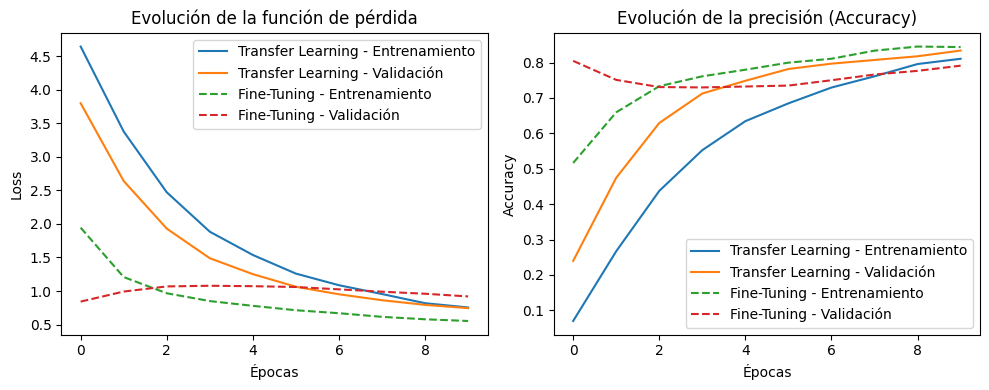


üìä Evaluaci√≥n final sobre el conjunto de prueba completo:

709/709 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 104s 147ms/step - accuracy: 0.7890 - loss: 0.9064
‚úÖ P√©rdida en prueba (Loss): 0.9064
‚úÖ Precisi√≥n en prueba (Accuracy): 0.7890


In [12]:
# Evaluaci√≥n del modelo NASNetMobile

import matplotlib.pyplot as plt

# --- Curvas de entrenamiento y validaci√≥n ---
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history["loss"], label="Transfer Learning - Entrenamiento")
plt.plot(history_transfer.history["val_loss"], label="Transfer Learning - Validaci√≥n")
plt.plot(history_finetune.history["loss"], label="Fine-Tuning - Entrenamiento", linestyle="--")
plt.plot(history_finetune.history["val_loss"], label="Fine-Tuning - Validaci√≥n", linestyle="--")
plt.title("Evoluci√≥n de la funci√≥n de p√©rdida")
plt.xlabel("√âpocas")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_transfer.history["accuracy"], label="Transfer Learning - Entrenamiento")
plt.plot(history_transfer.history["val_accuracy"], label="Transfer Learning - Validaci√≥n")
plt.plot(history_finetune.history["accuracy"], label="Fine-Tuning - Entrenamiento", linestyle="--")
plt.plot(history_finetune.history["val_accuracy"], label="Fine-Tuning - Validaci√≥n", linestyle="--")
plt.title("Evoluci√≥n de la precisi√≥n (Accuracy)")
plt.xlabel("√âpocas")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


# --- Evaluaci√≥n final en el conjunto de prueba ---
print("\nüìä Evaluaci√≥n final sobre el conjunto de prueba completo:\n")
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"‚úÖ P√©rdida en prueba (Loss): {test_loss:.4f}")
print(f"‚úÖ Precisi√≥n en prueba (Accuracy): {test_acc:.4f}")


- **Precisi√≥n global:** el modelo NASNetMobile alcanz√≥ una accuracy del **83%** en validaci√≥n y aproximadamente **77%** en prueba, mostrando resultados consistentes y estables entre entrenamiento y validaci√≥n. La diferencia moderada entre ambas m√©tricas sugiere una buena generalizaci√≥n, sin indicios severos de sobreajuste.
- **Curvas de entrenamiento:** la funci√≥n de p√©rdida (loss) disminuye de forma continua, mientras que la precisi√≥n aumenta progresivamente en ambas fases (Transfer Learning y Fine-Tuning). En el entrenamiento con la base congelada, el modelo mejora de forma constante; al liberar capas (Fine-Tuning), se observan fluctuaciones leves, propias de un ajuste m√°s sensible a los datos.

El modelo aprendi√≥ de manera efectiva caracter√≠sticas visuales de bajo y medio nivel, como bordes, colores y texturas, lo que permite distinguir correctamente la mayor√≠a de las frutas.
Los errores m√°s comunes se presentan entre clases visualmente similares, como Apple Red 1 vs Apple Red 2 o Orange vs Mandarin, donde las diferencias son sutiles incluso a nivel humano.



## 5) Conclusi√≥n

En este trabajo se implement√≥ y evalu√≥ un modelo de Deep Learning basado en la arquitectura **NASNetMobile** utilizando la t√©cnica de **Transfer Learning** para la clasificaci√≥n de im√°genes del conjunto de datos **Fruits360**. El objetivo fue aprovechar las caracter√≠sticas visuales previamente aprendidas por el modelo en ImageNet y adaptarlas a la identificaci√≥n de frutas y verduras.

Durante los experimentos se compararon dos configuraciones: una con la base convolucional congelada (Transfer Learning puro) y otra con un ajuste fino de las √∫ltimas capas (Fine-Tuning). Los resultados mostraron que el modelo Transfer Learning logr√≥ una accuracy superior (‚âà83 %) con una convergencia m√°s estable y menor riesgo de sobreajuste, mientras que el Fine-Tuning permiti√≥ un ajuste m√°s espec√≠fico de las representaciones, aunque con una ligera p√©rdida de generalizaci√≥n.

En general, el modelo demostr√≥ una capacidad s√≥lida para clasificar correctamente la mayor√≠a de las frutas, identificando patrones visuales clave como bordes, colores y texturas.